# Differential expression analysis [Meta Cell]

Sometimes we need to compare differentially expressed genes or differentially expressed features between two cell types on single cell data, but existing methods focus more on cell-specific gene analysis. Researchers need to transfer bulk RNA-seq analysis to single-cell analysis, which involves interaction between different programming languages or programming tools, adding significantly to the workload of the researcher.

Here, we use omicverse's bulk RNA-seq pyDEG method to complete differential expression analysis at the single cell level. We will present two different perspectives, one from the perspective of all cells and one from the perspective of the metacellular.

Colab_Reproducibility：https://colab.research.google.com/drive/12faBRh0xT7v6KSy8NCSRqbegF_AEoDXr?usp=sharing

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 04日 星期一 16:51:37 CST


## Data preprocessed 

We need to normalized and scale the data at first.

In [2]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [3]:
adata.X.max()

2286.0

We found that the max value of anndata object larger than 10 and type is int. We need to normalize and log1p it

In [4]:
#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

🖥️ Using CPU mode for QC...

📊 Step 1: Calculating QC Metrics
   Mitochondrial genes (prefix 'MT-'): 0 found
   ✓ QC metrics calculated:
     • Mean nUMIs: 6675 (range: 3020-18524)
     • Mean genes: 2516 (range: 1473-4492)
     • Mean mitochondrial %: 0.0% (max: 0.0%)
   📈 Original cell count: 3,696

🔧 Step 2: Quality Filtering (SEURAT)
   Thresholds: mito≤0.05, nUMIs≥500, genes≥250
   📊 Seurat Filter Results:
     • nUMIs filter (≥500): 0 cells failed (0.0%)
     • Genes filter (≥250): 0 cells failed (0.0%)
     • Mitochondrial filter (≤0.05): 0 cells failed (0.0%)
   ✓ Filters applied successfully
   ✓ Combined QC filters: 0 cells removed (0.0%)

🎯 Step 3: Final Filtering
   Parameters: min_genes=200, min_cells=3
   Ratios: max_genes_ratio=1, max_cells_ratio=1
filtered out 12261 genes that are detected in less than 3 cells
   ✓ Final filtering: 0 cells, 12,261 genes removed

🔍 Step 4: Doublet Detection
   ⚠️  Note: 'scrublet' detection is too old and may not work properly
   💡 Consi

In [5]:
adata.X.max()

11.971903

## Different expression in total level

We then select the target cells to be analysed, including `Alpha` and `Beta`, derive the expression matrix using `to_df()` and build the differential expression analysis module using `pyDEG`

In [6]:
test_adata=adata[adata.obs['clusters'].isin(['Alpha','Beta'])]
test_adata

View of AnnData object with n_obs × n_vars = 1064 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'highly_variable_genes', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'spliced', 'unspliced', 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

In [7]:
dds=ov.bulk.pyDEG(test_adata.to_df(layer='counts').T)

In [8]:
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


We also need to set up an experimental group and a control group, i.e. the two types of cells to be compared and analysed

In [9]:
treatment_groups=test_adata.obs[test_adata.obs['clusters']=='Alpha'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['clusters']=='Beta'].index.tolist()
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest')


⚙️ You are using ttest method for differential expression analysis.
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.


In [10]:
result.sort_values('qvalue').head()

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
index,,,,,,,,,,,,
Adra2a,0.0,0.0,0.008437,0.842735,0.424499,-1.236167,-6.888977,6.888977,0.000844,inf,inf,sig
Dlk1,0.0,0.0,0.266040,12.393163,7.844807,2.971738,-1.910284,1.910284,0.026604,inf,inf,sig
Gm27033,0.0,0.0,0.053690,0.909402,0.478709,-1.062778,-4.219211,4.219211,0.005369,inf,inf,sig
Nnat,0.0,0.0,0.046847,34.420513,18.016102,4.171215,-4.415893,4.415893,0.004685,inf,inf,sig
Enho,0.0,0.0,0.118545,1.362393,0.761572,-0.392947,-3.076493,3.076493,0.011855,inf,inf,sig


In [11]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 0.8307482004165649


🌋 Volcano Plot Analysis:
   Total genes: 1928
   ↗️  Upregulated genes: 187
   ↘️  Downregulated genes: 230
   ➡️  Non-significant genes: 1511
   🎯 Total significant genes: 417
   log2FC range: -7.82 to 7.91
   qvalue range: 0.00e+00 to 9.99e-01

⚙️  Current Function Parameters:
   Data columns: pval_name='qvalue', fc_name='log2FC'
   Thresholds: pval_threshold=0.05, fc_max=0.8307482004165649, fc_min=-0.8307482004165649
   Plot size: figsize=(4, 4)
   Gene labels: plot_genes_num=8, plot_genes_fontsize=12
   Custom genes: None (auto-select top genes)

💡 Parameter Optimization Suggestions:
   ▶ Wide fold change range detected:
     Current: fc_max=0.8307482004165649, fc_min=-0.8307482004165649
     Suggested: fc_max=2.6, fc_min=-2.3

   📋 Copy-paste ready function call:
   ov.pl.volcano(result, fc_max=2.6, fc_min=-2.3)
────────────────────────────────────────────────────────────


<Axes: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

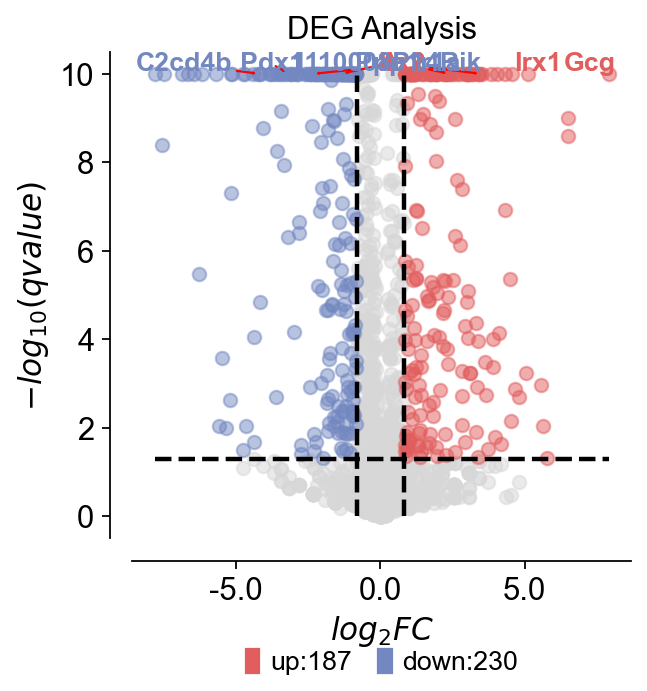

In [12]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <Axes: title={'center': 'Gene Expression'}>)

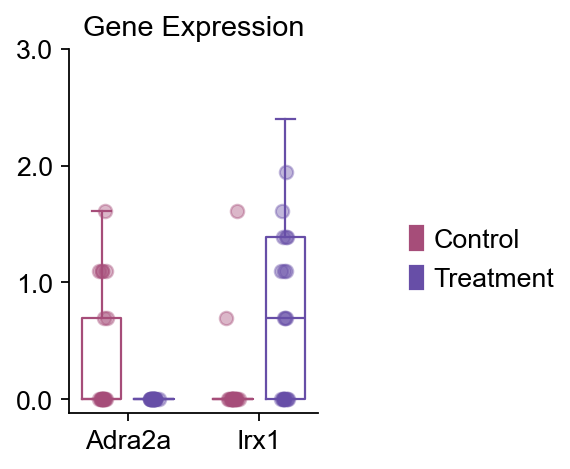

In [13]:
dds.plot_boxplot(genes=['Irx1','Adra2a'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

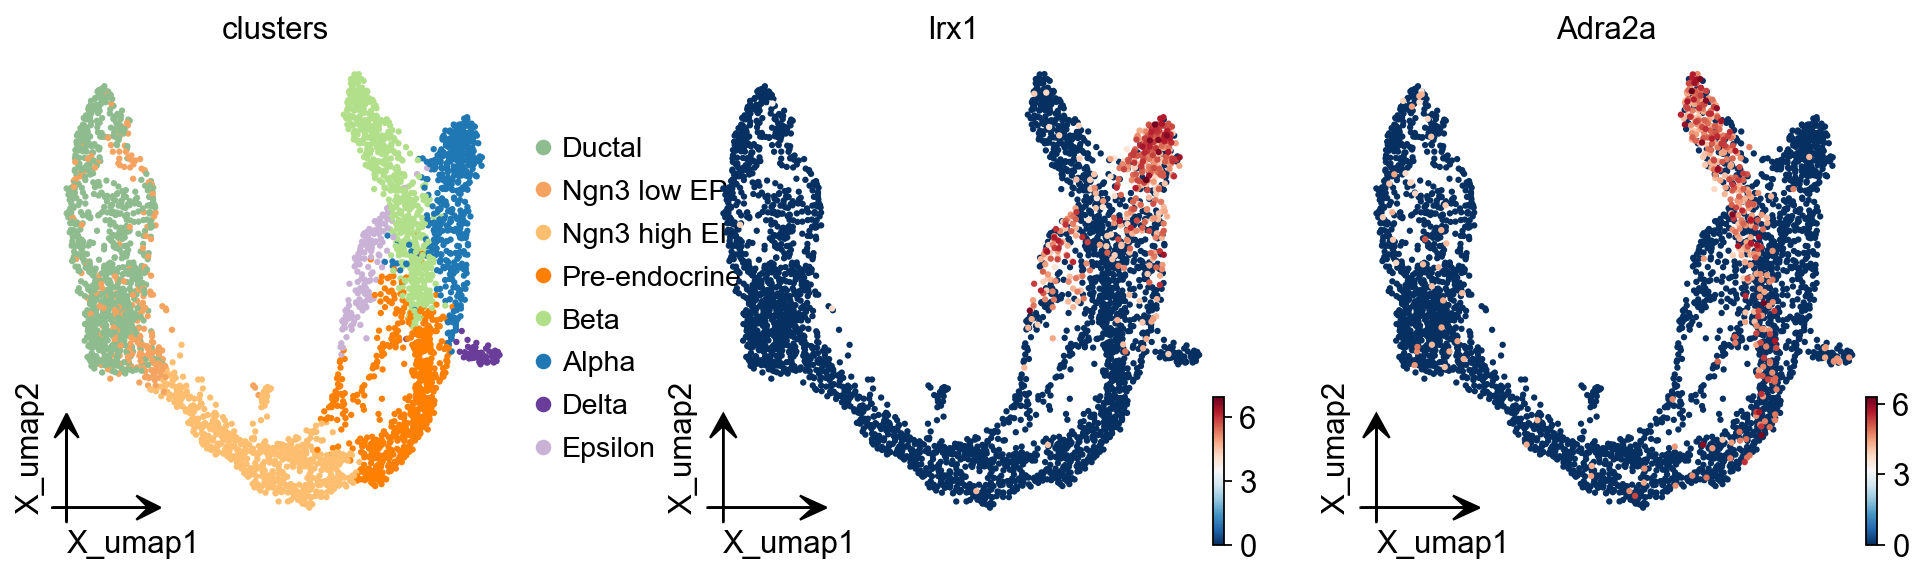

In [14]:
ov.utils.embedding(adata,
                   basis='X_umap',
                    frameon='small',
                   color=['clusters','Irx1','Adra2a'])

## Different expression in Metacells level

Here, we calculated the metacells from the whole scRNA-seq datasets using SEACells, and the same analyze with total level.

### Constructing a metacellular object

We can use `ov.single.MetaCell` to construct a metacellular object to train the SEACells model, the arguments can be found in below.

- :param ad: (AnnData) annotated data matrix
- :param build_kernel_on: (str) key corresponding to matrix in ad.obsm which is used to compute kernel for metacells
                        Typically 'X_pca' for scRNA or 'X_svd' for scATAC
- :param n_SEACells: (int) number of SEACells to compute
- :param use_gpu: (bool) whether to use GPU for computation
- :param verbose: (bool) whether to suppress verbose program logging
- :param n_waypoint_eigs: (int) number of eigenvectors to use for waypoint initialization
- :param n_neighbors: (int) number of nearest neighbors to use for graph construction
- :param convergence_epsilon: (float) convergence threshold for Franke-Wolfe algorithm
- :param l2_penalty: (float) L2 penalty for Franke-Wolfe algorithm
- :param max_franke_wolfe_iters: (int) maximum number of iterations for Franke-Wolfe algorithm
- :param use_sparse: (bool) whether to use sparse matrix operations. Currently only supported for CPU implementation.

In [15]:
meta_obj=ov.single.MetaCell(adata,use_rep='scaled|original|X_pca',n_metacells=150,
                           use_gpu=True)

Welcome to SEACells GPU!


In [16]:
meta_obj.initialize_archetypes()

Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3687 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3687 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3687 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on scaled|original|X_pca
Computing diffusion components from scaled|original|X_pca for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
Done.
Sampling waypoints ...
Done.
Selecting 137 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 23/23 [00:00<00:00, 225.28it/s]

Selecting 13 cells from greedy initialization.


## Train and save the model

In [17]:
meta_obj.train(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.10186
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Converged after 11 iterations.


In [18]:
meta_obj.save('seacells/model.pkl')

In [19]:
meta_obj.load('seacells/model.pkl')

## Predicted the metacells

we can use `predicted` to predicted the metacells of raw scRNA-seq data. There are two method can be selected, one is `soft`, the other is `hard`. 

In the `soft` method, Aggregates cells within each SEACell, summing over all raw data x assignment weight for all cells belonging to a SEACell. Data is un-normalized and pseudo-raw aggregated counts are stored in .layers['raw']. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

In the `hard` method, Aggregates cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. Data is unnormalized and raw aggregated counts are stored .layers['raw']. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

In [20]:
ad=meta_obj.predicted(method='soft',celltype_label='clusters',
                     summarize_layer='counts')

100%|██████████| 150/150 [00:13<00:00, 11.08it/s]


In [21]:
ad.X.min(),ad.X.max()

(0.0, 955.4641476114437)

<Axes: title={'center': 'Meta cells'}, xlabel='X_umap1', ylabel='X_umap2'>

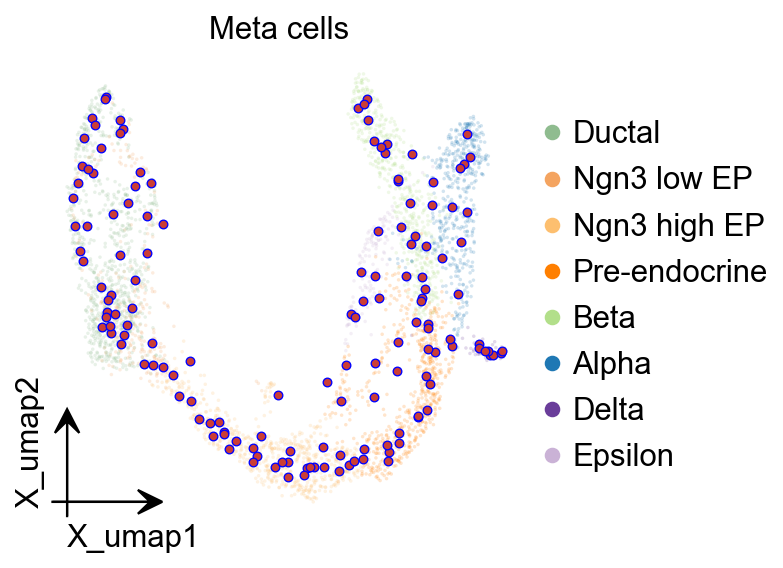

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    meta_obj.adata,
    basis="X_umap",
    color=['clusters'],
    frameon='small',
    title="Meta cells",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    size=10,
    ax=ax,
    alpha=0.2,
    #legend_loc='', 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
    #palette=ov.utils.blue_color[:],
    #legend_fontweight='normal'
)
ov.single._metacell.plot_metacells(ax,meta_obj.adata,color='#CB3E35',
                                  )

### Differentially expressed analysis

Similar to total cells for differential expression analysis, we used metacells for differential expression in the same way.

In [23]:
test_adata=ad[ad.obs['celltype'].isin(['Alpha','Beta'])]
test_adata

View of AnnData object with n_obs × n_vars = 29 × 2000
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [24]:
dds_meta=ov.bulk.pyDEG(test_adata.to_df().T)

In [25]:
dds_meta.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


We also need to set up an experimental group and a control group, i.e. the two types of cells to be compared and analysed

In [26]:
treatment_groups=test_adata.obs[test_adata.obs['celltype']=='Alpha'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['celltype']=='Beta'].index.tolist()
result=dds_meta.deg_analysis(treatment_groups,control_groups,method='ttest')

⚙️ You are using ttest method for differential expression analysis.
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.


In [27]:
result.sort_values('qvalue').head()

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
index,,,,,,,,,,,,
Smarca1,7.359387e-14,2.676141e-12,5.696915,2.477639,1.456246,0.542255,2.510181,2.510181,0.569692,13.133158,11.572491,sig
Gm20554,3.318760e-12,1.185271e-10,8.452424,0.190055,0.106240,-3.234596,3.079365,3.079365,0.845242,11.479024,9.926182,sig
Ctxn2,7.447717e-12,2.613234e-10,11.209452,0.968944,0.527661,-0.922316,3.486644,3.486644,1.120945,11.127977,9.582822,sig
Etv1,4.442996e-11,1.532068e-09,7.713388,1.388584,0.784274,-0.350570,2.947365,2.947365,0.771339,10.352324,8.814722,sig
Gria2,4.651881e-11,1.576909e-09,16.707512,0.365159,0.193476,-2.369773,4.062425,4.062425,1.670751,10.332371,8.802193,sig


In [28]:
# -1 means automatically calculates
dds_meta.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 1.100708495640502


🌋 Volcano Plot Analysis:
   Total genes: 1946
   ↗️  Upregulated genes: 183
   ↘️  Downregulated genes: 149
   ➡️  Non-significant genes: 1614
   🎯 Total significant genes: 332
   log2FC range: -9.05 to 9.40
   qvalue range: 2.68e-12 to 9.99e-01

⚙️  Current Function Parameters:
   Data columns: pval_name='qvalue', fc_name='log2FC'
   Thresholds: pval_threshold=0.05, fc_max=1.100708495640502, fc_min=-1.100708495640502
   Plot size: figsize=(4, 4)
   Gene labels: plot_genes_num=8, plot_genes_fontsize=12
   Custom genes: None (auto-select top genes)

💡 Parameter Optimization Suggestions:
   ▶ Wide fold change range detected:
     Current: fc_max=1.100708495640502, fc_min=-1.100708495640502
     Suggested: fc_max=3.6, fc_min=-3.2

   📋 Copy-paste ready function call:
   ov.pl.volcano(result, fc_max=3.6, fc_min=-3.2)
────────────────────────────────────────────────────────────


<Axes: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

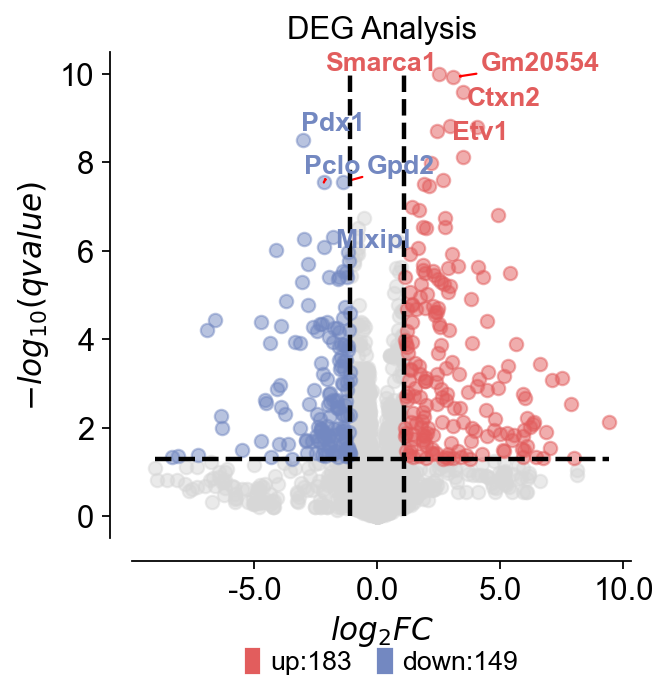

In [29]:
dds_meta.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <Axes: title={'center': 'Gene Expression'}>)

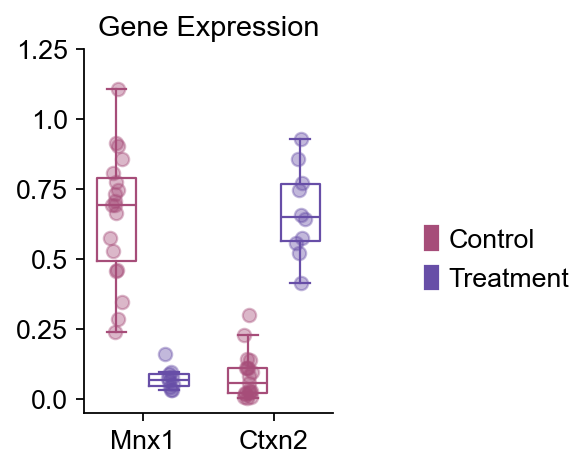

In [30]:
dds_meta.plot_boxplot(genes=['Ctxn2','Mnx1'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

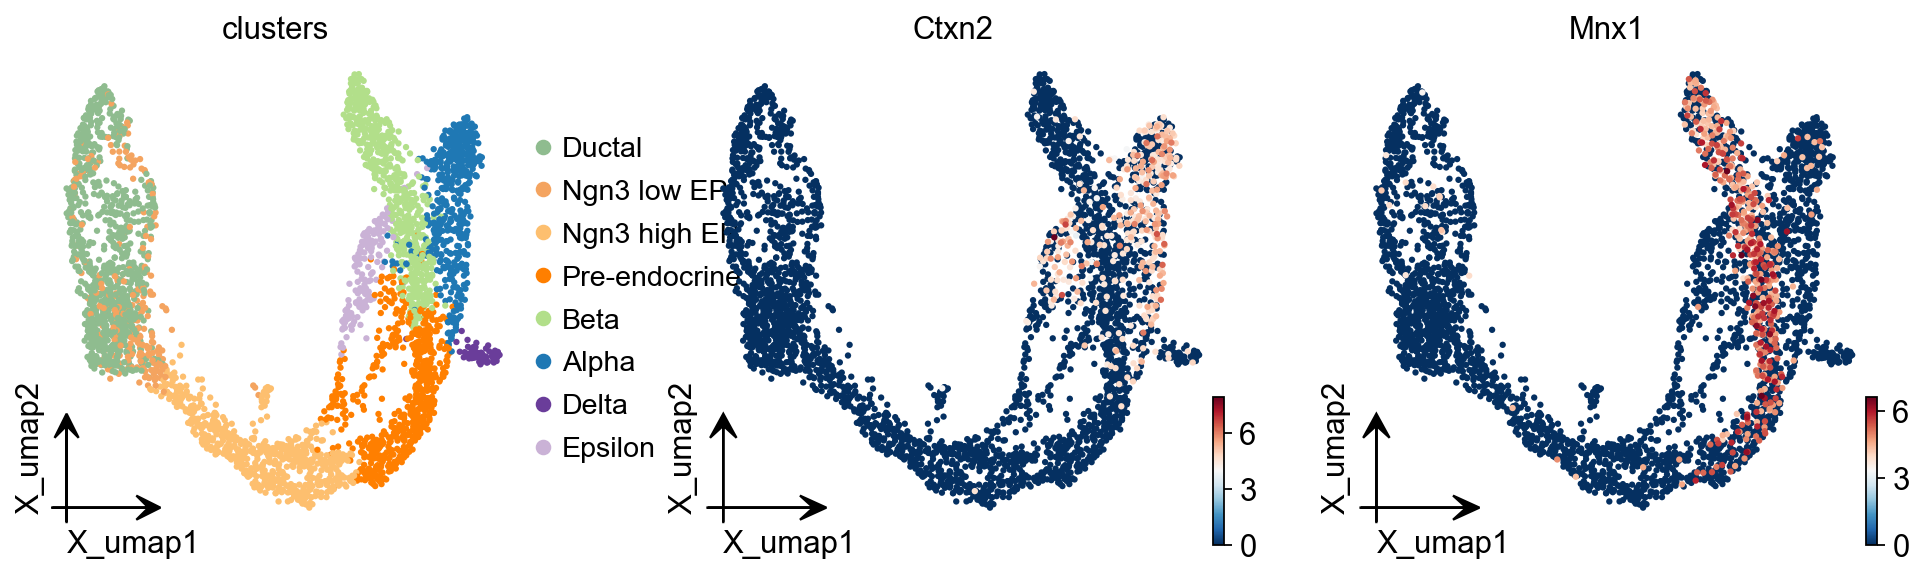

In [31]:
ov.utils.embedding(adata,
                   basis='X_umap',
                    frameon='small',
                   color=['clusters','Ctxn2','Mnx1'])